# BLINK Accuracy Benchmarking

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, '../')

import blink

import matchms as mms
from matchms.exporting import save_as_mgf
from matchms.similarity import CosineGreedy, ModifiedCosine

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def create_mms_spectra(row):
    """
    create MatchMS formated spectra
    """
    cols = ['name', 'precursor_mz','inchi', 'smiles', 'spectrumid']
    metadata = row[cols].to_dict()
    spectrum = mms.Spectrum(mz=np.array(row['spectrum'][0], dtype="float"), intensities=np.array(row['spectrum'][1], dtype="float"), metadata=metadata)
    
    return spectrum

def filter_spectra(row, decimal=4):
    """
    filter noise ions and round m/z values to a consistent decimal place
    """
    idx = np.argwhere(abs(row['spectrum'][0]-row['precursor_mz'])>14).flatten()
    filtered_spectrum = row['spectrum'][:,idx]
    filtered_spectrum = filtered_spectrum.round(decimal)
    
    return filtered_spectrum

# Generate Test Data

In [3]:
#load test spectra with blink
berkeley_lab_spectra = blink.open_msms_file('/global/homes/t/tharwood/spectral_libraries/BERKELEY-LAB.mgf')

#sample spectra for 1 million comparisons
small_mgf = berkeley_lab_spectra.sample(1000)
medium_mgf = berkeley_lab_spectra.sample(10000)

#format spectra for MatchMS
small_spectra = small_mgf.apply(lambda x: create_mms_spectra(x), axis=1)
small_spectra = small_spectra.tolist()

medium_spectra = medium_mgf.apply(lambda x: create_mms_spectra(x), axis=1)
medium_spectra = medium_spectra.tolist()

#save spectra
save_as_mgf(small_spectra, 'accuracy_test_data/small.mgf')
save_as_mgf(medium_spectra, 'accuracy_test_data/medium.mgf')

/global/homes/t/tharwood/.conda/envs/blink-env/lib/python3.7/site-packages/pyteomics/auxiliary/file_helpers.py:595: FutureWarning: Opening an existing file in append mode. The default mode will change from 'a' to 'w' in a future version. Pass `file_mode='a'` to keep old behavior and suppress this warning.
  "Pass `file_mode='a'` to keep old behavior and suppress this warning.", FutureWarning)


# Load & Filter Test Data

In [4]:
small  = blink.open_msms_file('accuracy_test_data/small.mgf')
medium = blink.open_msms_file('accuracy_test_data/medium.mgf')

#remove all zero intensity ions
small.spectrum = blink.filter_spectra(small.spectrum, small.precursor_mz)
medium.spectrum = blink.filter_spectra(medium.spectrum, medium.precursor_mz)

#remove ions within m/z tolerance of one another in spectrum
small.spectrum = blink.remove_duplicate_ions(small.spectrum)
medium.spectrum = blink.remove_duplicate_ions(medium.spectrum)

#filter and round m/z values using function defined in cell 2
small.spectrum = small.apply(lambda x: filter_spectra(x), axis=1)
medium.spectrum = medium.apply(lambda x: filter_spectra(x), axis=1)

#convert spectra into BLINK sparse matrix format
S1 = blink.discretize_spectra(small.spectrum,  small.precursor_mz,  intensity_power=0.5, bin_width=0.0001)
S2 = blink.discretize_spectra(medium.spectrum, medium.precursor_mz, intensity_power=0.5, bin_width=0.0001)

../blink.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mzis[bad_idx] = np.asarray([mz,intensity])


# Make 1 Million Comparisons Using BLINK

In [5]:
%%time
S12 = blink.score_sparse_spectra(S1, S2, tolerance=0.001)

CPU times: user 313 ms, sys: 40.2 ms, total: 353 ms
Wall time: 352 ms


# Make Same Comparisons Using MatchMS

In [6]:
#format spectra for MatchMS
MMS1 = small.apply(lambda x: create_mms_spectra(x), axis=1)
MMS2 = medium.apply(lambda x: create_mms_spectra(x), axis=1)

#MatchMS parameters
cos = CosineGreedy(tolerance=0.00099,intensity_power=0.5)
mod = ModifiedCosine(tolerance=0.00099,intensity_power=0.5)

In [7]:
%%time
MMS12 = {}
MMS12['cos'] = cos.matrix(references=MMS1, queries=MMS2)
MMS12['mod'] = mod.matrix(references=MMS1, queries=MMS2)

CPU times: user 10min 53s, sys: 119 ms, total: 10min 53s
Wall time: 10min 53s


# Visualize & Save Results

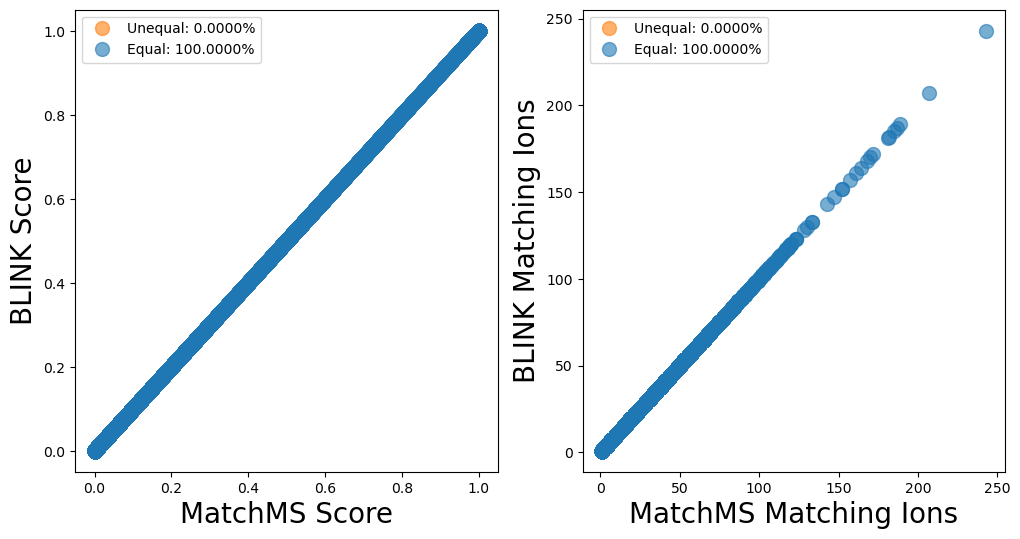

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6),nrows=1,ncols=2)
ax = ax.flatten()

x = MMS12['cos']['score'].flatten()
y = S12['mzi'].toarray().flatten()

# one or both have to be non-zero
idx = (x*y)>0
x = x[idx]
y = y[idx]
nonzero_score = len(x)

# indices that are more than 1% different
idx_diff = abs(x-y)>0.0001
different_score = sum(idx_diff)

# median difference of scores score more than 1% different
if different_score > 0:
    diff = (x[idx_diff] - y[idx_diff])
    median_diff_score = np.median(diff)
else:
    median_diff_score = 0

ax[0].plot(x[idx_diff], y[idx_diff],'.', markersize=20, alpha=0.6,label='Unequal: %.4f%%'%(100*different_score/nonzero_score), color='#ff7f0e')
ax[0].plot(x[~idx_diff], y[~idx_diff], '.',markersize=20, alpha=0.6, label='Equal: %.4f%%'%(100*(nonzero_score-different_score)/nonzero_score), color='#1f77b4')
ax[0].set_xlabel('MatchMS Score',fontsize=20)
ax[0].set_ylabel('BLINK Score',fontsize=20)
ax[0].legend()

x = MMS12['cos']['matches'].flatten()
y = S12['mzc'].toarray().flatten()

# one or both have to be non-zero
idx = (x*y)>0
x = x[idx]
y = y[idx]
nonzero_matches = len(x)

# indices where match counts don't agree
idx_diff = abs(x-y)>0
different_matches = sum(idx_diff)

# median difference of different matches 
if different_matches > 0:
    diff = (x[idx_diff] - y[idx_diff])
    median_diff_matches = np.median(diff)
else:
    median_diff_matches = 0

ax[1].plot(x[idx_diff], y[idx_diff],'.', markersize=20, alpha=0.6,label='Unequal: %.4f%%'%(100*different_matches/nonzero_matches), color='#ff7f0e')
ax[1].plot(x[~idx_diff], y[~idx_diff], '.',markersize=20, alpha=0.6, label='Equal: %.4f%%'%(100*(nonzero_matches-different_matches)/nonzero_matches), color='#1f77b4')
ax[1].set_xlabel('MatchMS Matching Ions',fontsize=20)
ax[1].set_ylabel('BLINK Matching Ions',fontsize=20)
ax[1].legend()

# fig.savefig('cos_accuracy_benchmarking.pdf')

In [9]:
cos_results = {}

cos_results['equal_score'] = nonzero_score-different_score
cos_results['unequal_score'] = different_score
cos_results['median_diff_score'] = median_diff_score

cos_results['equal_matches'] = nonzero_matches-different_matches
cos_results['unequal_matches'] = different_matches
cos_results['median_diff_matches'] = median_diff_matches

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6),nrows=1,ncols=2)
ax = ax.flatten()

x = MMS12['mod']['score'].flatten()
y = np.maximum(S12['mzi'].toarray().flatten(),S12['nli'].toarray().flatten())

# one or both have to be non-zero
idx = (x*y)>0
x = x[idx]
y = y[idx]
nonzero_score = len(x)

# indices that are more than 1% different
idx_diff = abs(x-y)>0.0001
different_score = sum(idx_diff)

# median difference of scores score more than 1% different
if different_score > 0:
    diff = (x[idx_diff] - y[idx_diff])
    median_diff_score = np.median(diff)
else:
    median_diff_score = 0

ax[0].plot(x[idx_diff], y[idx_diff],'.', markersize=20, alpha=0.6,label='Unequal: %.4f%%'%(100*different_score/nonzero_score), color='#ff7f0e')
ax[0].plot(x[~idx_diff], y[~idx_diff], '.',markersize=20, alpha=0.6, label='Equal: %.4f%%'%(100*(nonzero_score-different_score)/nonzero_score), color='#1f77b4')
ax[0].set_xlabel('MatchMS Score',fontsize=20)
ax[0].set_ylabel('BLINK Score',fontsize=20)
ax[0].legend()

x = MMS12['cos']['matches'].flatten()
y = S12['mzc'].toarray().flatten()

# one or both have to be non-zero
idx = (x*y)>0
x = x[idx]
y = y[idx]
nonzero_matches = len(x)

# indices where match counts don't agree
idx_diff = abs(x-y)>0
different_matches = sum(idx_diff)

# median difference of different matches 
if different_matches > 0:
    diff = (x[idx_diff] - y[idx_diff])
    median_diff_matches = np.median(diff)
else:
    median_diff_matches = 0

ax[1].plot(x[idx_diff], y[idx_diff],'.', markersize=20, alpha=0.6,label='Unequal: %.4f%%'%(100*different_matches/nonzero_matches), color='#ff7f0e')
ax[1].plot(x[~idx_diff], y[~idx_diff], '.',markersize=20, alpha=0.6, label='Equal: %.4f%%'%(100*(nonzero_matches-different_matches)/nonzero_matches), color='#1f77b4')
ax[1].set_xlabel('MatchMS Matching Ions',fontsize=20)
ax[1].set_ylabel('BLINK Matching Ions',fontsize=20)
ax[1].legend()

# fig.savefig('mod_accuracy_benchmarking.pdf')

In [ ]:
mod_results = {}

mod_results['equal_score'] = nonzero_score-different_score
mod_results['unequal_score'] = different_score
mod_results['median_diff_score'] = median_diff_score

mod_results['equal_matches'] = nonzero_matches-different_matches
mod_results['unequal_matches'] = different_matches
mod_results['median_diff_matches'] = median_diff_matches

In [ ]:
#create dataframe and save as csv
df = pd.DataFrame(
    
 [(cos_results['equal_score'], cos_results['unequal_score'], cos_results['median_diff_score']),
  (cos_results['equal_matches'], cos_results['unequal_matches'], cos_results['median_diff_matches']),
  (mod_results['equal_score'], mod_results['unequal_score'], mod_results['median_diff_score']),
  (mod_results['equal_matches'], mod_results['unequal_matches'], mod_results['median_diff_matches'])],
    
 index = ['cos_score', 'cos_matches', 'mod_cos_score', 'mod_cos_matches'],
 columns = ('equal', 'unequal', 'median_diff'), 
    
)

df.to_csv('accuracy_benchmarking_results.csv')